In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import numpy as np
import torchvision.transforms as T
import torch
from torch.utils.data import Dataset
import cv2
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from albumentations.core.transforms_interface import ImageOnlyTransform

/Users/tnluser/opt/anaconda3/envs/ocr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [216]:
train_dataset_path = '../dataset/handwritten_math_symbols/train/'
eval_dataset_path = '../dataset/handwritten_math_symbols/eval/'
test_dataset_path = '../data/server_uploaded/test/'
crohme_dataset_path = '../dataset/crohm_symbols/'

In [194]:
class Erosin(ImageOnlyTransform):
    def apply(self, img, **params):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 6, 2)))
        img = cv2.erode(img, kernel, iterations=1)
        return img
    
class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 4, 2)))
        img = cv2.dilate(img, kernel, iterations=1)
        return img
    
class ToBlackAndWhite(ImageOnlyTransform):
    def __init__(self, invert=False, always_apply=False, p=0.5):
        super(ToBlackAndWhite, self).__init__(always_apply, p)
        self.invert = invert
        
    def apply(self, img, **params):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if self.invert==True:
           return 1 - img/255 
        return img/255

In [160]:
model_input_shape = (32, 32)
train_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1),
    A.Resize(width=100, height=100),
    A.Perspective(
        scale=(0.08, 0.12),
        p=0.5,
        fit_output=True,
        pad_val=(1.0),
    ),
    Dilation(p=0.5),
    Erosin(p=0.5),
    A.Rotate(limit=20, p=0.5, value=(1.0), border_mode=cv2.BORDER_CONSTANT),
    A.Resize(width=model_input_shape[0], height=model_input_shape[1]),
    A.PadIfNeeded(
        min_width=model_input_shape[0]+6,
        min_height=model_input_shape[1]+6,
        value=(1.0),
        border_mode=cv2.BORDER_CONSTANT,
        p=1
    ),
    A.RandomCrop(model_input_shape[0], model_input_shape[1]),
    ToTensorV2()
])

In [149]:
# A.ToGray?

In [161]:
train_dataset_org = torchvision.datasets.ImageFolder(root=train_dataset_path)
# eval_dataset = torchvision.datasets.ImageFolder(root=eval_dataset_path, transform=eval_dataset_transform)

In [215]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        paths = []
        class_to_idx = {}
        idx_to_class = {}
        class_count = {}
        for i, label in enumerate(os.listdir(root)):
            files = os.listdir(root+label)
            paths += [[root+label+'/'+p, label] for p in files] 
            class_to_idx[label] = i+0
            class_count[label] = len(files)
            idx_to_class[i+0] = label
        self.class_to_idx = class_to_idx
        self.idx_to_class = idx_to_class
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_filepath, label = self.paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, self.class_to_idx[label]
train_dataset = ImageDataset(root=train_dataset_path, transform=train_dataset_transform)

torch.Size([1, 32, 32])


100it [00:00, 681.59it/s]


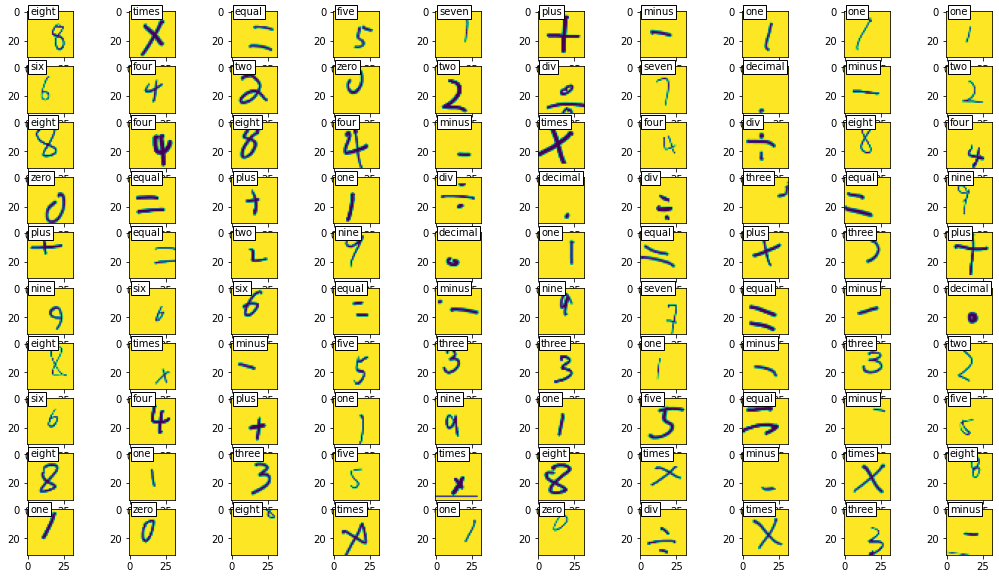

In [200]:
import math
from tqdm import tqdm
plt.rcParams['figure.figsize'] = [18, 10]
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=100,  shuffle=True) 
    batch = next(iter(loader))
    images, labels = batch
    width = 10
    f, axarr = plt.subplots(math.ceil(len(labels)/width), width)
    row, col = 0, 0
    print(images[0].shape)
    for i, image in tqdm(enumerate(images)):
        label = dataset.idx_to_class[int(labels[i])]
        axarr[row,col].imshow(np.transpose(image, (1, 2, 0)))
        axarr[row,col].text(2, 2, label , bbox={'facecolor': 'white', 'pad': 2})
        col+=1
        if(col%width == 0):
            row+=1
            col = 0
    plt.show()
show_transformed_images(train_dataset)

# Eval Augmentation

In [201]:
eval_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1),
    A.Resize(width=model_input_shape[0], height=model_input_shape[0]),
    ToTensorV2()
])

In [202]:
eval_dataset = ImageDataset(root=eval_dataset_path, transform=eval_dataset_transform)

In [214]:
eval_dataset.class_to_idx

{'eight': 0,
 'decimal val': 1,
 'nine': 2,
 'times val': 3,
 'minus val': 4,
 'three': 5,
 'equal val': 6,
 'one': 7,
 'zero': 8,
 'seven': 9,
 'div val': 10,
 'two': 11,
 'six': 12,
 'plus val': 13,
 'five': 14,
 'four': 15}

torch.Size([1, 32, 32])


100it [00:00, 717.54it/s]


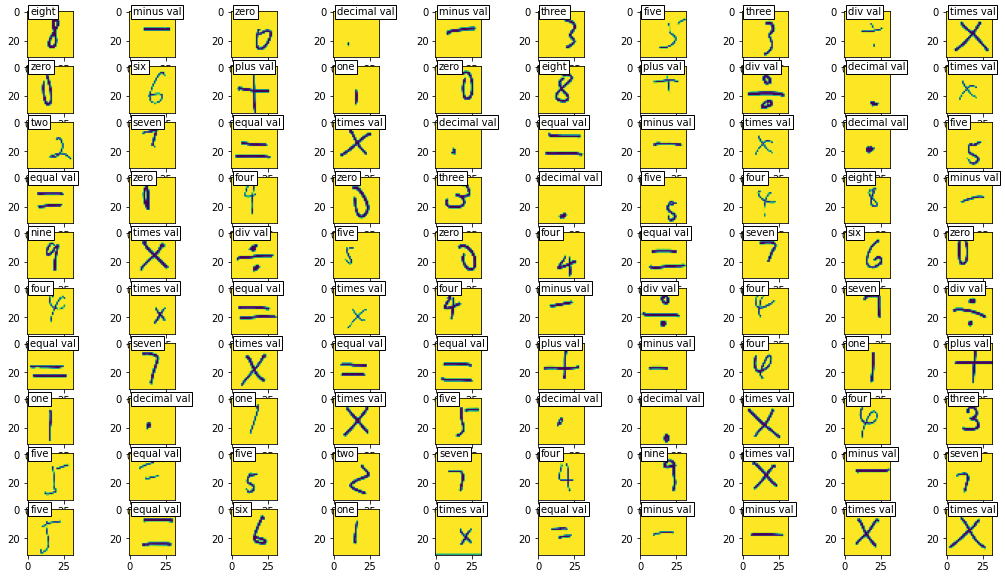

In [203]:
show_transformed_images(eval_dataset)

# Test Data

In [212]:
test_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1, invert=True),
    A.Resize(width=model_input_shape[0], height=model_input_shape[0]),
    ToTensorV2()
])

test_dataset = ImageDataset(root=test_dataset_path, transform=test_dataset_transform)

torch.Size([1, 32, 32])


100it [00:00, 657.02it/s]


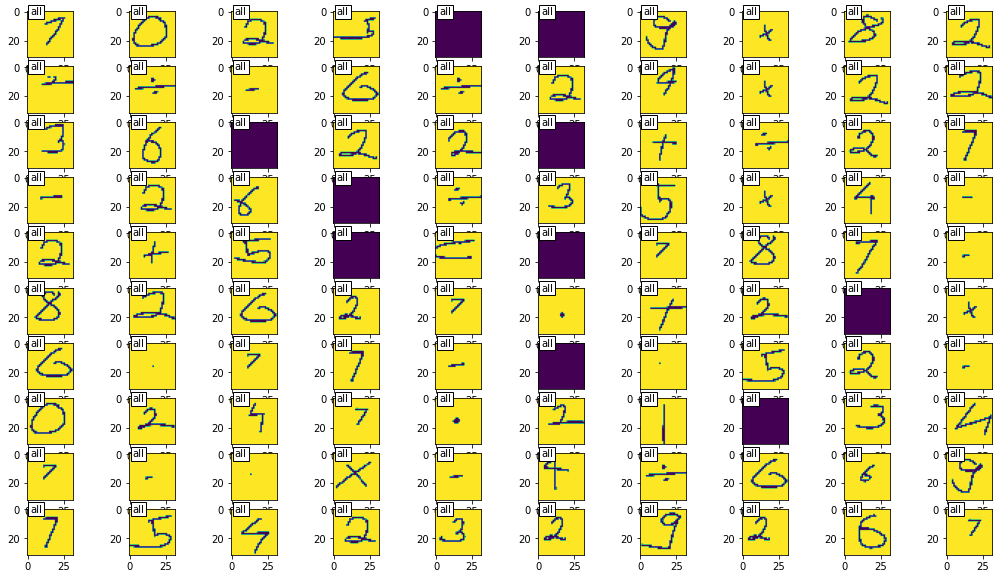

In [213]:
show_transformed_images(test_dataset)

# Crohm Dataset by Classes

In [227]:
crohm_dataset_transform = A.Compose([
    ToBlackAndWhite(p=1),
    A.Resize(width=50, height=50),
    A.Perspective(
        scale=(0.08, 0.12),
        p=0.5,
        fit_output=True,
        pad_val=(1.0),
    ),
    Dilation(p=0.5),
    Erosin(p=0.5),
    A.Rotate(limit=20, p=0.5, value=(1.0), border_mode=cv2.BORDER_CONSTANT),
    A.Resize(width=model_input_shape[0], height=model_input_shape[1]),
    A.PadIfNeeded(
        min_width=model_input_shape[0]+6,
        min_height=model_input_shape[1]+6,
        value=(1.0),
        border_mode=cv2.BORDER_CONSTANT,
        p=1
    ),
    A.RandomCrop(model_input_shape[0], model_input_shape[1]),
    ToTensorV2()
])

In [228]:
crohm_dataset = ImageDataset(root=crohme_dataset_path, transform=crohm_dataset_transform)

torch.Size([1, 32, 32])


100it [00:00, 643.48it/s]


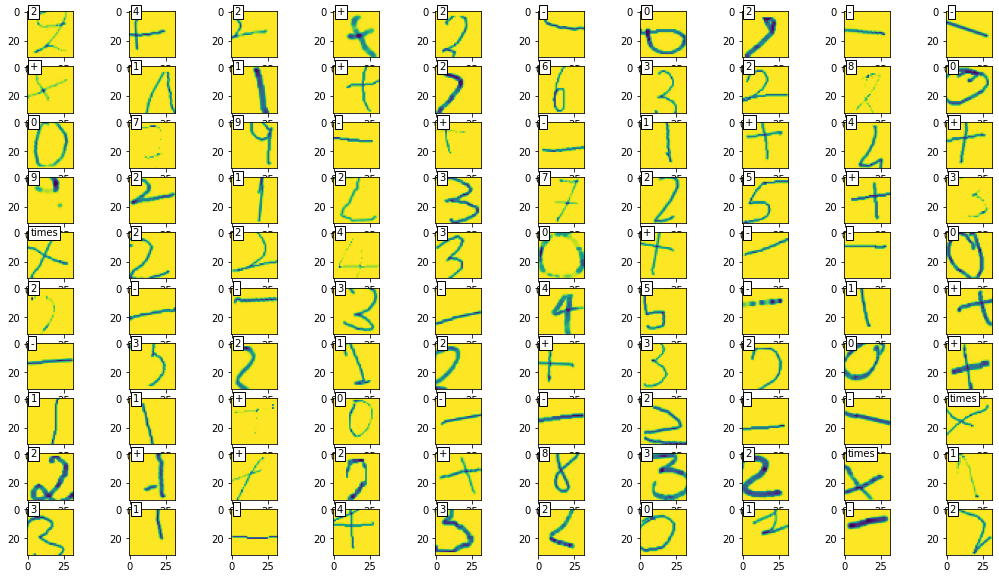

In [229]:
show_transformed_images(crohm_dataset)